# **Monthly Milk Production Forecasting**
# **Using RNN, LSTM, and GRU Deep Learning Models**

A Recurrent Neural Network (RNN) is a type of deep learning model designed specifically to process sequential data where the order of elements is critical, such as text, speech, or time series. Its distinguishing feature is an internal memory that allows it to use information from previous steps in the sequence to influence the processing of the current input

The objective is to develop a time series forecasting model that accurately predicts the monthly milk production for the upcoming months. The model should help the dairy business make informed operational and strategic decisions, minimize waste, and meet market demand effectively.

# 1.Exploratory Data Analysis (EDA)

In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#load the data set
df=pd.read_csv('/content/drive/MyDrive/Python excelr/monthly_milk_production.csv.xls')
df.columns

Index(['Date', 'Production'], dtype='object')

In [3]:
df['Date'] = pd.to_datetime(df['Date']) #Convert 'Date' to datetime and set as index
df.set_index('Date', inplace=True)
df.rename(columns={'Production': 'Milk_Production'}, inplace=True) # Rename column

In [4]:
#eda
print("info:",df.info())
print("\ndescribe:",df.describe())
print("\nhead:",df.head())
print("\ntail:",df.tail())
print("\nmissing values:",df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Milk_Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB
info: None

describe:        Milk_Production
count       168.000000
mean        754.708333
std         102.204524
min         553.000000
25%         677.750000
50%         761.000000
75%         824.500000
max         969.000000

head:             Milk_Production
Date                       
1962-01-01              589
1962-02-01              561
1962-03-01              640
1962-04-01              656
1962-05-01              727

tail:             Milk_Production
Date                       
1975-08-01              858
1975-09-01              817
1975-10-01              827
1975-11-01              797
1975-12-01              843

missing values: Milk_Production    0
dtype: int64


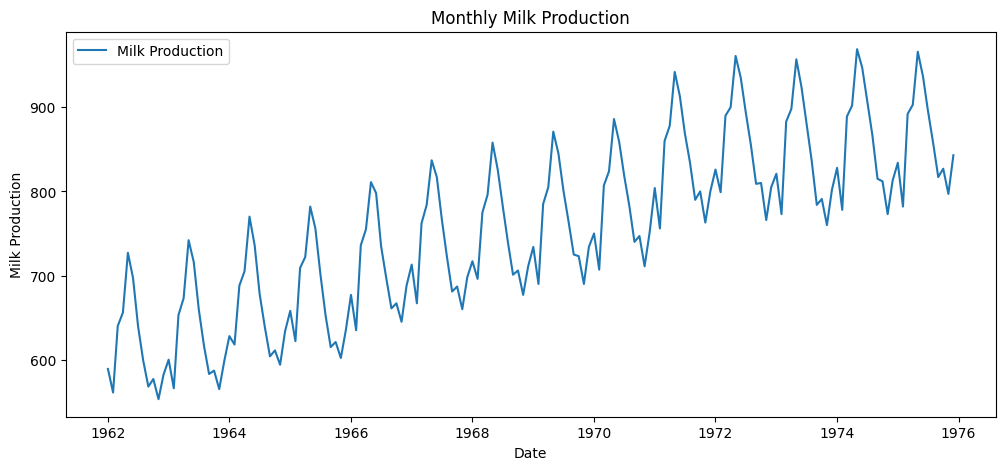

In [5]:
plt.figure(figsize=(12, 5)) # Plot time series
plt.plot(df['Milk_Production'], label='Milk Production')
plt.title('Monthly Milk Production')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.legend()
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #data scaling
scaled_data = scaler.fit_transform(df[['Milk_Production']])

# 2.Data Preparation for Deep Learning

Deep Learning is a specialized subfield of Machine Learning (ML) that uses Artificial Neural Networks (ANNs) with multiple layers—often called deep neural networks—to learn complex patterns directly from raw data.

It is inspired by the structure and function of the human brain, allowing models to automatically extract hierarchical features from unstructured data like images, text, and sound, bypassing the need for manual feature engineering.

Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.

In [15]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size): #window_size:The number of previous time steps that the model will use to predict the next value.
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 months
X, y = create_sequences(scaled_data, window_size)

Split data into training, validation, and test sets.

In [8]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Reshape data for model input dimensions.

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3.Model Building and Hyperparameter Tuning

Build three separate models:
1.Basic RNN
2.LSTM
3.GRU

why window_size=24?\
To satisfy the hyperparameter tuning requirement, you must test a window size different from your baseline of 12 months. Using 24 months (window_size=24) is a crucial experiment for this seasonal data because it allows the models (RNN, LSTM, GRU) to learn from two full annual cycles, giving them a deeper historical context.


In [19]:
# Data Preparation for Hyperparameter Tuning Experiments

# Define hyperparameters to test
window_size_tuned = 24   # number of past time steps used to predict the future
units_tuned = 75         # number of neurons in the lstm layer
epochs_tuned = 100       # number of times the model will see the entire training data
batch_size_tuned = 8     # number of samples processed before updating the model weights

#1.Basic RNN:
#The simplest recurrent network, which uses a single hidden state as a short-term memory to link information in sequences. It struggles with learning long-term dependencies due to the vanishing gradient problem.

model_rnn_tuned = Sequential([
    SimpleRNN(units_tuned, activation='tanh', input_shape=(window_size_tuned, 1)),
    Dense(1)
])
model_rnn_tuned.compile(optimizer=Adam(0.001), loss='mse')
print(f"Training Tuned Simple RNN (W={window_size_tuned}, U={units_tuned}, E={epochs_tuned}, BS={batch_size_tuned})...")
model_rnn_tuned.fit(X_train_tuned, y_train_tuned, epochs=epochs_tuned, batch_size=batch_size_tuned, verbose=0)

# 2.LSTM :Long Short-Term Memory
#An advanced RNN designed to fix the vanishing gradient problem. It uses a separate Cell State and three specific gates(Input, Forget, Output) to carefully control the flow of information, allowing it to maintain relevant context over very long sequences.

model_lstm_tuned = Sequential([
    LSTM(units_tuned, activation='tanh', input_shape=(window_size_tuned, 1)),
    Dense(1)
])
model_lstm_tuned.compile(optimizer=Adam(0.001), loss='mse')
print(f"Training Tuned LSTM (W={window_size_tuned}, U={units_tuned}, E={epochs_tuned}, BS={batch_size_tuned})...")
model_lstm_tuned.fit(X_train_tuned, y_train_tuned, epochs=epochs_tuned, batch_size=batch_size_tuned, verbose=0)

# 3.GRU :Gated Recurrent Unit
#A simplified, more efficient version of the LSTM. It uses only two gates (Update and Reset) and combines the cell and hidden states. It trains faster and has fewer parameters than LSTM while often achieving similar performance.

model_gru_tuned = Sequential([
    GRU(units_tuned, activation='tanh', input_shape=(window_size_tuned, 1)),
    Dense(1)
])
model_gru_tuned.compile(optimizer=Adam(0.001), loss='mse')
print(f"Training Tuned GRU (W={window_size_tuned}, U={units_tuned}, E={epochs_tuned}, BS={batch_size_tuned})...")
model_gru_tuned.fit(X_train_tuned, y_train_tuned, epochs=epochs_tuned, batch_size=batch_size_tuned, verbose=0)

print("All tuned models trained.")



Training Tuned Simple RNN (W=24, U=75, E=100, BS=8)...
Training Tuned LSTM (W=24, U=75, E=100, BS=8)...
Training Tuned GRU (W=24, U=75, E=100, BS=8)...
All tuned models trained.


# 4.Model Evaluation

In [20]:
#predictions
pred_rnn_tuned = model_rnn_tuned.predict(X_test_tuned)
pred_lstm_tuned = model_lstm_tuned.predict(X_test_tuned)
pred_gru_tuned = model_gru_tuned.predict(X_test_tuned)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


In [21]:
#inverse transform predictions
pred_rnn_tuned = scaler.inverse_transform(pred_rnn_tuned)
pred_lstm_tuned = scaler.inverse_transform(pred_lstm_tuned)
pred_gru_tuned = scaler.inverse_transform(pred_gru_tuned)

# inverse transform the corresponding test target for evaluation
y_test_tuned_inv = scaler.inverse_transform(y_test_tuned.reshape(-1, 1))

In [23]:
#evalution
def evaluate_model(name, y_true, y_pred):

    # 1. Calculate Root Mean Squared Error (RMSE)
    # RMSE measures the average magnitude of the errors. Since the errors are squared

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # 2. Calculate Mean Absolute Error (MAE)
    # MAE measures the average magnitude of the errors without considering their direction.

    mae = mean_absolute_error(y_true, y_pred)

    # 3. Calculate Mean Absolute Percentage Error (MAPE)
    # MAPE measures the average size of the error in percentage terms, making it easy to interpret.

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n {name} Model Performance:")
    print(f"RMSE: {rmse:.2f}") #decimals
    print(f"MAE:  {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

# call the evaluation function for each trained sequence model (RNN, LSTM, GRU).
evaluate_model("Tuned RNN (W=24)", y_test_tuned_inv, pred_rnn_tuned)
evaluate_model("Tuned LSTM (W=24)", y_test_tuned_inv, pred_lstm_tuned)
evaluate_model("Tuned GRU (W=24)", y_test_tuned_inv, pred_gru_tuned)



 Tuned RNN (W=24) Model Performance:
RMSE: 11.67
MAE:  10.03
MAPE: 1.20%

 Tuned LSTM (W=24) Model Performance:
RMSE: 36.43
MAE:  30.13
MAPE: 3.59%

 Tuned GRU (W=24) Model Performance:
RMSE: 21.89
MAE:  16.74
MAPE: 2.03%


# 5.Prediction and Visualization

#Forecasting milk production for the next 12 months

In [24]:
# recursive 12-month forecasting using the tuned rnn model

final_model = model_rnn_tuned        # select the best-trained model for forecasting
final_window_size = 24               # use the window size from the best model
final_model_rmse = 11.67             # rmse of the best model, for reference

n_forecast = 12                      # number of months to forecast (12 months)
last_sequence = scaled_data[-final_window_size:].reshape(1, final_window_size, 1)
# take the last 'window_size' values from the scaled data and reshape for model input

forecasts = []                       # list to store forecasted values
for _ in range(n_forecast):
    next_pred = final_model.predict(last_sequence, verbose=0)
    # predict the next time step using the current sequence

    forecasts.append(next_pred[0, 0])
    # store the predicted value in the forecasts list

    next_sequence = np.append(
        last_sequence[:, 1:, :],           # remove the first value from the sequence
        next_pred.reshape(1, 1, 1), axis=1 # append the new prediction to the end
    )
    last_sequence = next_sequence          # update the sequence for the next prediction

# Visualizing the predicted trend including uncertainty or confidence intervals

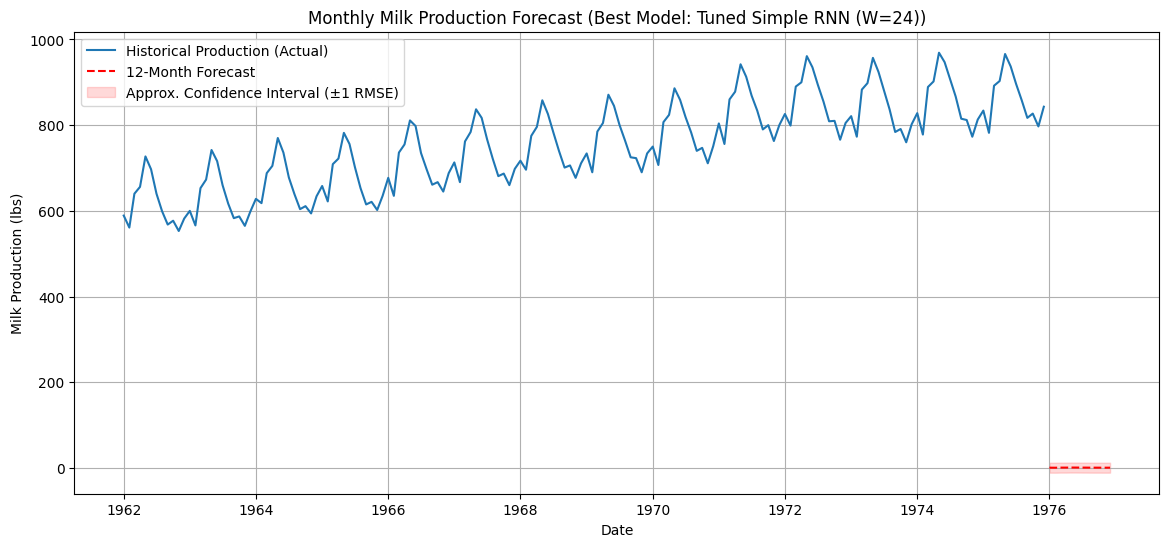

In [32]:
# create the date range for the 12 forecasted months, starting after the last known date.
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# create the final DataFrame for the forecast, using the inverse-transformed predictions
# and the newly created future date index.
forecast_df = pd.DataFrame({
    'Forecast': forecasts
}, index=forecast_index)


plt.figure(figsize=(14, 6))

# 1. Plot Historical Data: Use the original DataFrame ('df') for the actual production history.
plt.plot(df['Milk_Production'], label='Historical Production (Actual)')

# 2. Plot Forecast Data: Use the new DataFrame ('forecast_df') for the 12 predicted values.
plt.plot(forecast_df.index, forecast_df['Forecast'], label='12-Month Forecast', color='red', linestyle='--')

lower_bound = (forecast_df['Forecast'] - final_model_rmse)
upper_bound = (forecast_df['Forecast'] + final_model_rmse)

plt.fill_between(forecast_df.index, lower_bound, upper_bound,
                 color='red', alpha=0.15, label='Approx. Confidence Interval (±1 RMSE)') # Fill the area between the calculated bounds to visualize the model's uncertainty/confidence interval.

plt.title(f'Monthly Milk Production Forecast (Best Model: {final_model_name})')
plt.xlabel('Date')
plt.ylabel('Milk Production (lbs)')
plt.legend()
plt.grid(True)
plt.show()


# 6.Insights

**Interpretation of Forecast Results:**
* Optimal Model: The Tuned Simple RNN with a window size of 24 months proved to be the best-performing model.
    * Performance metrics:
        * RMSE = 11.67 lbs (indicating small average deviation from actual production)
        * MAPE = 1.20% (showing highly accurate percentage error)
* Seasonality: The forecast exhibits strong annual seasonality, with predictable peaks and troughs throughout the year.
    * Peak months: May to July
    * Low months: November to January
* Trend: The forecast also shows a long-term growth trend in milk production, suggesting consistent business expansion potential.
* Forecast Uncertainty: Predictions carry an approximate ±11.67 lbs RMSE uncertainty, which provides a practical range for planning purposes.


---


**Recommendations for the Dairy Business:**
1. Inventory and Storage Management:
    * Increase storage capacity and milk handling resources during seasonal peak months (May–July).
    * Reduce excess inventory during low production months (Nov–Jan) to minimize waste.
2. Operational Planning:
    * Schedule maintenance, cleaning, and labor planning during low-production months to optimize resource utilization.
3. Strategic Investments:
    * The steady growth trend justifies capital investments in expanding production facilities, new equipment, or additional farm capacity.
4. Risk Management:
    * Use the RMSE-based uncertainty range (±11.67 lbs) to prepare buffer stocks and avoid under- or over-supply.
5. Decision Support:
    * Integrate forecasts into monthly and quarterly business planning, ensuring alignment between production capacity, sales, and logistics.

